## 1. Frequency Analysis Setup

**Methods for Research Question 1 (Frequency)**  

This section focuses on **Frequency Analysis**, where we measure how the \textit{annual counts} of PubMed papers and SBIR projects for each MeSH term evolve over time, and how they may be related. Specifically, we:

1. Import the necessary libraries and define paths.
2. Specify the set of **years** (2010–2021) for our time-series data.
3. Prepare to load the pickled dictionaries containing hierarchical MeSH information and annual frequencies for both publications and SBIR awards.

This groundwork lets us track how many publications or SBIRs exist for each MeSH term in each year.

In [11]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.stattools import grangercausalitytests

PICKLES_ADDRESS = 'pickles/'
LAG_DATA_ADDRESS = '../lag_data/'

## 2. Loading and Filtering Data

We now load the pickled files containing:
- **MeSH Hierarchy**: `dui2level`, `level2duis`, `dui2children`, etc.
- **Frequency Data**: `dui2pubfreq`, `dui2sbfreq` (and their “child” versions).
- **Other Info**: Intersections, excluded DUIs, etc.

After loading, we filter out DUIs (`exduis`) that never appear in SBIR data across our entire timespan. This helps us focus only on MeSH terms with non-zero frequencies in at least one year.

In [3]:
years = [str(year) for year in range(2010, 2022)]
START_YEAR, START_YEAR_IDX, SF_TAG = 2010, 0, 'SF10'
correlation_lags = list(range(-11 + START_YEAR_IDX, 11 - (START_YEAR_IDX - 1)))
print('years:', years)
print('correlation_lags:', correlation_lags)

with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
    print('dui2children:', len(dui2children))
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))
with open(PICKLES_ADDRESS + 'heading2dui_final.pkl', 'rb') as handle:
    dui2name = pickle.load(handle)
    print('dui2name:', len(dui2name))
with open(PICKLES_ADDRESS + 'dui2header_final.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
    print('name2dui:', len(name2dui))
with open(PICKLES_ADDRESS + 'dui2level_final.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)
    print('dui2level:', len(dui2level))
with open(PICKLES_ADDRESS + 'level2duis_final.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
    print('level2duis:', len(level2duis))
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2trail = pickle.load(handle)
    print('dui2trail:', len(dui2trail))
with open(PICKLES_ADDRESS + 'dui_intersection_final.pkl', 'rb') as handle:
    dui_intersections = pickle.load(handle)
    print('dui_intersections:', len(dui_intersections))
with open(PICKLES_ADDRESS + 'excluded_duis_final.pkl', 'rb') as handle:
    excluded_duis = pickle.load(handle)
    print('excluded_duis:', len(excluded_duis))
with open(PICKLES_ADDRESS + 'dui2pubfreq.pkl', 'rb') as handle:
    dui2pubfreq = pickle.load(handle)
    print('dui2pubfreq:', len(dui2pubfreq))
with open(PICKLES_ADDRESS + 'dui2sbfreq.pkl', 'rb') as handle:
    dui2sbfreq = pickle.load(handle)
    print('dui2sbfreq:', len(dui2sbfreq))
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
    print('dui2pubfreqchild:', len(dui2pubfreqchild))
with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
    print('dui2sbfreqchild:', len(dui2sbfreqchild))
with open(PICKLES_ADDRESS + 'dui2pubcit.pkl', 'rb') as handle:
    dui2pubcit = pickle.load(handle)
    print('dui2pubcit:', len(dui2pubcit))
with open(PICKLES_ADDRESS + 'dui2sbcit.pkl', 'rb') as handle:
    dui2sbcit = pickle.load(handle)
    print('dui2sbcit:', len(dui2sbcit))
with open(PICKLES_ADDRESS + 'dui2pubcitchild.pkl', 'rb') as handle:
    dui2pubcitchild = pickle.load(handle)
    print('dui2pubcitchild:', len(dui2pubcitchild))
with open(PICKLES_ADDRESS + 'dui2sbcitchild.pkl', 'rb') as handle:
    dui2sbcitchild = pickle.load(handle)
    print('dui2sbcitchild:', len(dui2sbcitchild))

years: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
correlation_lags: [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
dui2children: 29432
dui2parents: 29307
dui2name: 29307
name2dui: 29307
dui2level: 29307
level2duis: 14
dui2trail: 29432
dui_intersections: 29307
excluded_duis: 723
dui2pubfreq: 29307
dui2sbfreq: 29307
dui2pubfreqchild: 29307
dui2sbfreqchild: 29307
dui2pubcit: 29307
dui2sbcit: 29307
dui2pubcitchild: 29307
dui2sbcitchild: 29307


In [5]:
# store all duis that have no frequency at any year of the dui2pubfreq dictionary and store them in a list called exduis
exduis = {}
for dui in dui2sbfreq:
    c = 0
    for year in years:
        c += len(dui2sbfreq[dui][year])
    if c == 0:
        exduis[dui] = True
    else:
        exduis[dui] = False

len(exduis)

29307

In [6]:
# for each dui in dui2pubfreq and dui2sbfreq, generate a time series of the number of pmids and sbids at each year and return dui2pubFreqSig and dui2sbFreqSig.
dui2pubFreqSig = {}
dui2sbFreqSig = {}
for dui in tqdm(dui2pubfreq):
    if not exduis[dui]:
        dui2pubFreqSig[dui] = []
        dui2sbFreqSig[dui] = []
        for year in years[START_YEAR_IDX:]:
            dui2pubFreqSig[dui].append(len(dui2pubfreq[dui][year]))
            dui2sbFreqSig[dui].append(len(dui2sbfreq[dui][year]))

# for each dui in dui2pubfreqchild and dui2sbfreqchild, generate a time series of the number of pmids and sbids at each year and return dui2pubFreqSigchild and dui2sbFreqSigchild.
dui2pubFreqSigchild = {}
dui2sbFreqSigchild = {}
for dui in tqdm(dui2pubfreqchild):
    if not exduis[dui]:
        dui2pubFreqSigchild[dui] = []
        dui2sbFreqSigchild[dui] = []
        for year in years[START_YEAR_IDX:]:
            dui2pubFreqSigchild[dui].append(len(dui2pubfreqchild[dui][year]))
            dui2sbFreqSigchild[dui].append(len(dui2sbfreqchild[dui][year]))

100%|██████████| 29307/29307 [00:00<00:00, 444553.02it/s]


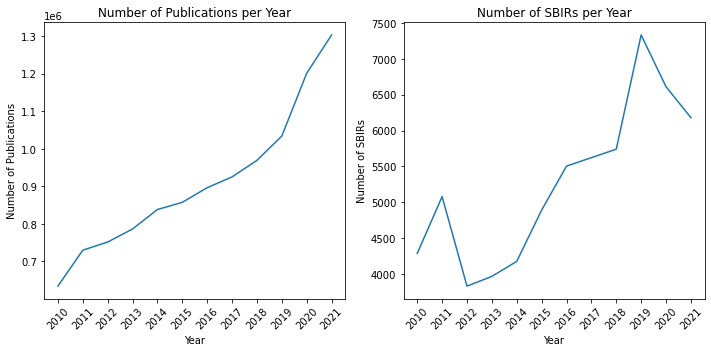

In [7]:
total_pubs_per_year = {}
for year in years:
    total_pubs_per_year[year] = []
    for dui in dui2pubfreq:
        if not exduis[dui]:
            total_pubs_per_year[year] += dui2pubfreq[dui][year]
    total_pubs_per_year[year] = len(set(total_pubs_per_year[year]))

total_sbirs_per_year = {}
for year in years:
    total_sbirs_per_year[year] = []
    for dui in dui2sbfreq:
        if not exduis[dui]:
            total_sbirs_per_year[year] += dui2sbfreq[dui][year]
    total_sbirs_per_year[year] = len(set(total_sbirs_per_year[year]))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(total_pubs_per_year.keys(), total_pubs_per_year.values())
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Publications')
axs[0].set_title('Number of Publications per Year')
axs[1].plot(total_sbirs_per_year.keys(), total_sbirs_per_year.values())
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Number of SBIRs')
axs[1].set_title('Number of SBIRs per Year')

for ax in axs:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

## 3. Constructing and Normalizing Frequency Signals

**Frequency Representation**  

Here, we:
1. Count the annual number of **PubMed papers** (`dui2pubFreqSig`) and **SBIR projects** (`dui2sbFreqSig`) for each MeSH term.
2. Convert raw counts into \textit{proportions} (`dui2pubFreqSigProp`, `dui2sbFreqSigProp`) by dividing by the total PubMed/SBIR counts in that year. 
3. Apply Min-Max scaling (\([0,1]\) range) to manage varying scales among different MeSH terms, storing results in, for example, `dui2pubFreqSigPropScaled` and `dui2sbFreqSigPropScaled`.

This step quantifies each MeSH topic’s \textit{relative} share of publications or SBIR grants per year.

In [8]:
# now divide each dui2pubFreqSig and dui2sbFreqSig by the total number of publications and SBIRs per year to get the proportion of publications and SBIRs per year.
dui2pubFreqSigProp = {}
dui2sbFreqSigProp = {}
for dui in tqdm(dui2pubFreqSig):
    if not exduis[dui]:
        dui2pubFreqSigProp[dui] = []
        dui2sbFreqSigProp[dui] = []
        for i in range(len(years[START_YEAR_IDX:])):
            dui2pubFreqSigProp[dui].append(dui2pubFreqSig[dui][i] / total_pubs_per_year[years[i]])
            dui2sbFreqSigProp[dui].append(dui2sbFreqSig[dui][i] / total_sbirs_per_year[years[i]])

# now divide each dui2pubFreqSigchild and dui2sbFreqSigchild by the total number of publications and SBIRs per year to get the proportion of publications and SBIRs per year.
dui2pubFreqSigPropchild = {}
dui2sbFreqSigPropchild = {}
for dui in tqdm(dui2pubFreqSigchild):
    if not exduis[dui]:
        dui2pubFreqSigPropchild[dui] = []
        dui2sbFreqSigPropchild[dui] = []
        for i in range(len(years[START_YEAR_IDX:])):
            dui2pubFreqSigPropchild[dui].append(dui2pubFreqSigchild[dui][i] / total_pubs_per_year[years[i]])
            dui2sbFreqSigPropchild[dui].append(dui2sbFreqSigchild[dui][i] / total_sbirs_per_year[years[i]])

  0%|          | 0/10873 [00:00<?, ?it/s]

100%|██████████| 10873/10873 [00:00<00:00, 175982.63it/s]


In [9]:
# use minmax scaling to scale the values in dui2pubFreqSigProp and dui2sbFreqSigProp to be between 0 and 1. also account for ZeroDivisionError.
dui2pubFreqSigPropScaled = {}
dui2sbFreqSigPropScaled = {}
for dui in tqdm(dui2pubFreqSigProp):
    if not exduis[dui]:
        dui2pubFreqSigPropScaled[dui] = []
        dui2sbFreqSigPropScaled[dui] = []
        for i in range(len(years[START_YEAR_IDX:])):
            try:
                dui2pubFreqSigPropScaled[dui].append((dui2pubFreqSigProp[dui][i] - min(dui2pubFreqSigProp[dui])) / (max(dui2pubFreqSigProp[dui]) - min(dui2pubFreqSigProp[dui])))
            except ZeroDivisionError:
                dui2pubFreqSigPropScaled[dui].append(0)
            try:
                dui2sbFreqSigPropScaled[dui].append((dui2sbFreqSigProp[dui][i] - min(dui2sbFreqSigProp[dui])) / (max(dui2sbFreqSigProp[dui]) - min(dui2sbFreqSigProp[dui])))
            except ZeroDivisionError:
                dui2sbFreqSigPropScaled[dui].append(0)


dui2pubFreqSigPropScaledchild = {}
dui2sbFreqSigPropScaledchild = {}
for dui in tqdm(dui2pubFreqSigPropchild):
    if not exduis[dui]:
        dui2pubFreqSigPropScaledchild[dui] = []
        dui2sbFreqSigPropScaledchild[dui] = []
        for i in range(len(years[START_YEAR_IDX:])):
            try:
                dui2pubFreqSigPropScaledchild[dui].append((dui2pubFreqSigPropchild[dui][i] - min(dui2pubFreqSigPropchild[dui])) / (max(dui2pubFreqSigPropchild[dui]) - min(dui2pubFreqSigPropchild[dui])))
            except ZeroDivisionError:
                dui2pubFreqSigPropScaledchild[dui].append(0)
            try:
                dui2sbFreqSigPropScaledchild[dui].append((dui2sbFreqSigPropchild[dui][i] - min(dui2sbFreqSigPropchild[dui])) / (max(dui2sbFreqSigPropchild[dui]) - min(dui2sbFreqSigPropchild[dui])))
            except ZeroDivisionError:
                dui2sbFreqSigPropScaledchild[dui].append(0)

100%|██████████| 10873/10873 [00:00<00:00, 43904.09it/s]


In [12]:
#save dui2prubFreqSigPropScaledchild and dui2sbFreqSigPropScaledchild to pickle at data/pickles/
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubFreqSigPropScaled.pickle', 'wb') as handle:
    pickle.dump(dui2pubFreqSigPropScaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubFreqSigPropScaledchild.pickle', 'wb') as handle:
    pickle.dump(dui2pubFreqSigPropScaledchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbFreqSigPropScaled.pickle', 'wb') as handle:
    pickle.dump(dui2sbFreqSigPropScaled, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbFreqSigPropScaledchild.pickle', 'wb') as handle:
    pickle.dump(dui2sbFreqSigPropScaledchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Saved')

Saved


In [13]:
#load the four dictionaries from pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubFreqSigPropScaled.pickle', 'rb') as handle:
    dui2pubFreqSigPropScaled = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2pubFreqSigPropScaledchild.pickle', 'rb') as handle:
    dui2pubFreqSigPropScaledchild = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbFreqSigPropScaled.pickle', 'rb') as handle:
    dui2sbFreqSigPropScaled = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2sbFreqSigPropScaledchild.pickle', 'rb') as handle:
    dui2sbFreqSigPropScaledchild = pickle.load(handle)
print('Loaded')

Loaded


## 4. Granger Causality (Frequency Signals)

**Measurement of Trend Causality**  

Next, we test whether \textit{past frequency} of publications (or SBIR projects) predicts future frequency of the other domain. Concretely:

1. We prepare each MeSH term’s scaled frequency signals for PubMed and SBIR.
2. **Upsample** from 12 data points to 36 (3× for each year) to provide more granularity.
3. Use **Granger Causality** up to 11 lags (i.e., up to 11 years) to evaluate whether changes in scientific frequency lead or follow changes in SBIR frequency.

A p-value < 0.05 for a given lag indicates that the frequency in one domain helps predict future activity in the other.

In [14]:
#calculate the granger causality between two time series for up to 11 lags
def granger_causality(x, y, maxlag):
    result = grangercausalitytests(np.array([x, y]).T, maxlag=maxlag, verbose=False)
    return result

#create dui2gc dictionary to store the granger causality p-values for each dui
dui2gcChild = {}
c = 0
for dui in tqdm(dui2pubFreqSigPropScaledchild):
    sig_a = dui2pubFreqSigPropScaledchild[dui]
    sig_b = dui2sbFreqSigPropScaledchild[dui]
    #replace nans with 0s
    sig_a = np.nan_to_num(sig_a)
    sig_b = np.nan_to_num(sig_b)

    #upsample to to make the stretch the length of each signal from 12 to 36
    sig_a = np.repeat(sig_a, 3)
    sig_b = np.repeat(sig_b, 3)

    try:
        granger = granger_causality(sig_b, sig_a, 11)
        dui2gcChild[dui] = granger
    except Exception as e:
        if str(type(e)) == "<class 'statsmodels.tools.sm_exceptions.InfeasibleTestError'>":
            c += 1
            dui2gcChild[dui] = None

print(c)
#save dui2gc dictionary to a pickle file
with open(PICKLES_ADDRESS + 'dui2gcchild_freq.pickle', 'wb') as handle:
    pickle.dump(dui2gcChild, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('saved dui2gcChild')

  0%|          | 0/10873 [00:00<?, ?it/s]/home/admin/VS Code Projects/JPMC/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|██████████| 10873/10873 [02:18<00:00, 78.47it/s]


1653
saved dui2gcChild


In [15]:
#load dui2gc dictionary from pickle file
with open(PICKLES_ADDRESS + 'dui2gcchild_freq.pickle', 'rb') as handle:
    dui2gcChild = pickle.load(handle)
print('loaded dui2gcChild')

loaded dui2gcChild


In [16]:
max_depth = 13
mlag = 11
depth_wise_chi2tests_maxlen = []
depth_wise_chi2tests_std = []
depth_wise_lrtests_maxlen = []
depth_wise_lrtests_std = []
for depth in range(1, max_depth + 1):
    try:
        print('depth:', depth + 1)
        dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level] if dui in dui2gcChild]
        print('len(dui_subset):', len(dui_subset))

        lag2chi2tests = {}
        lag2lrtests = {}
        for lag in list(range(1, 12)):
            dui_subset_chi2tests = [dui2gcChild[dui][lag][0]['ssr_chi2test'][1] if dui2gcChild[dui] else 1 for dui in dui_subset]
            dui_subset_lrtests = [dui2gcChild[dui][lag][0]['lrtest'][1] if dui2gcChild[dui] else 1 for dui in dui_subset]

            chi2tests_significant_ratio = len([chi2test for chi2test in dui_subset_chi2tests if chi2test < 0.05]) / len(dui_subset_chi2tests)
            lrtests_significant_ratio = len([lrtest for lrtest in dui_subset_lrtests if lrtest < 0.05]) / len(dui_subset_lrtests)

            lag2chi2tests[lag] = chi2tests_significant_ratio
            lag2lrtests[lag] = lrtests_significant_ratio

        depth_wise_chi2tests_maxlen.append(lag2chi2tests[mlag])
        depth_wise_chi2tests_std.append(np.std(list(lag2chi2tests.values())))
        depth_wise_lrtests_maxlen.append(lag2lrtests[mlag])
        depth_wise_lrtests_std.append(np.std(list(lag2lrtests.values())))

        print('chi2tests_significant_ratio:', round(depth_wise_chi2tests_maxlen[-1], 4), '±', round(depth_wise_chi2tests_std[-1], 4))
        print('lrtests_significant_ratio:', round(depth_wise_lrtests_maxlen[-1], 4), '±', round(depth_wise_lrtests_std[-1], 4))
        print('=' * 50)
        #save the results to a pickle file
        with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_maxlen_freq.pickle', 'wb') as handle:
            pickle.dump(depth_wise_chi2tests_maxlen, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'depth_wise_chi2tests_std_freq.pickle', 'wb') as handle:
            pickle.dump(depth_wise_chi2tests_std, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'depth_wise_lrtests_maxlen_freq.pickle', 'wb') as handle:
            pickle.dump(depth_wise_lrtests_maxlen, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(PICKLES_ADDRESS + 'depth_wise_lrtests_std_freq.pickle', 'wb') as handle:
            pickle.dump(depth_wise_lrtests_std, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('saved')

    except:
        print('=' * 50)
        print('depth:', depth)
        print('=' * 50)

depth: 2
len(dui_subset): 58
chi2tests_significant_ratio: 0.7931 ± 0.2442
lrtests_significant_ratio: 0.6034 ± 0.2003
saved
depth: 3
len(dui_subset): 853
chi2tests_significant_ratio: 0.8523 ± 0.268
lrtests_significant_ratio: 0.7339 ± 0.2335
saved
depth: 4
len(dui_subset): 2976
chi2tests_significant_ratio: 0.8384 ± 0.2649
lrtests_significant_ratio: 0.7376 ± 0.2346
saved
depth: 5
len(dui_subset): 5653
chi2tests_significant_ratio: 0.8256 ± 0.2601
lrtests_significant_ratio: 0.7292 ± 0.231
saved
depth: 6
len(dui_subset): 7880
chi2tests_significant_ratio: 0.8147 ± 0.2576
lrtests_significant_ratio: 0.7217 ± 0.2291
saved
depth: 7
len(dui_subset): 9283
chi2tests_significant_ratio: 0.8085 ± 0.2563
lrtests_significant_ratio: 0.7164 ± 0.2278
saved
depth: 8
len(dui_subset): 10019
chi2tests_significant_ratio: 0.8046 ± 0.2552
lrtests_significant_ratio: 0.7122 ± 0.2265
saved
depth: 9
len(dui_subset): 10491
chi2tests_significant_ratio: 0.8008 ± 0.2538
lrtests_significant_ratio: 0.7086 ± 0.2252
saved
dep

## 5. Cross-Correlation and CCAUC for Frequency Signals

**Cross-Correlation Area Under the Curve**  

Here, we:
1. Compute the \textbf{cross-correlation} of the scaled publication and SBIR frequency signals to identify if one leads the other.
2. Identify the \textbf{maximum correlation lag} (MCCL).
3. Compute the **AUC ratio** by integrating the positive-lag (science → industry) portion and the negative-lag (industry → science) portion. A CCAUC > 1 indicates that **industrial signals** more likely lag scientific signals, while a ratio < 1 suggests the opposite.

We then visualize the distribution of these lags and ratios by MeSH depth to see how frequency-based signals vary across hierarchical topic levels.

In [17]:
# create a dui2cc dictionary that maps a dui to a scipy cross correlation between the scaled pub and sbir frequencies
dui2cc = {}
dui2ccchild = {}
for dui in tqdm(dui2pubFreqSigPropScaled):
    sigA, sigB = dui2pubFreqSigPropScaled[dui], dui2sbFreqSigPropScaled[dui]
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2cc[dui] = corr
for dui in tqdm(dui2pubFreqSigPropScaledchild):
    sigA, sigB = dui2pubFreqSigPropScaledchild[dui], dui2sbFreqSigPropScaledchild[dui]
    corr = signal.correlate(sigB, sigA, mode='full') / len(years)
    corr = corr.astype(np.float64)
    lags = signal.correlation_lags(len(sigB), len(sigA))
    corr /= np.max(corr) + 1e-8
    dui2ccchild[dui] = corr

#save the dui2cc and dui2ccchild dictionaries in data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2cc.pickle', 'wb') as handle:
    pickle.dump(dui2cc, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2ccchild.pickle', 'wb') as handle:
    pickle.dump(dui2ccchild, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10873/10873 [00:00<00:00, 49598.43it/s]


In [18]:
#load the dui2cc and dui2ccchild dictionaries from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2cc.pickle', 'rb') as handle:
    dui2cc = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2ccchild.pickle', 'rb') as handle:
    dui2ccchild = pickle.load(handle)

print('Loaded dui2cc and dui2ccchild.')

Loaded dui2cc and dui2ccchild.


In [19]:
# create dui2mcclag and dui2mcclagchild
dui2mcclag = {}
dui2mcclagchild = {}
dui2aucratio = {}
dui2aucratiochild = {}
for dui in tqdm(dui2cc):
    dui2mcclag[dui] = correlation_lags[np.argmax(dui2cc[dui])]
for dui in tqdm(dui2ccchild):
    dui2mcclagchild[dui] = correlation_lags[np.argmax(dui2ccchild[dui])]
    
for dui in tqdm(dui2cc):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2cc[dui][zero_index + 1:], dx=1)
    neg_auc = np.trapz(dui2cc[dui][:zero_index], dx=1)
    dui2aucratio[dui] = (pos_auc + 1) / (neg_auc + 1)
for dui in tqdm(dui2ccchild):
    zero_index = correlation_lags.index(0)
    pos_auc = np.trapz(dui2ccchild[dui][zero_index:], dx=1)
    neg_auc = np.trapz(dui2ccchild[dui][:zero_index], dx=1)
    dui2aucratiochild[dui] = (pos_auc + 1) / (neg_auc + 1)

with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclag.pickle', 'wb') as handle:
    pickle.dump(dui2mcclag, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclagchild.pickle', 'wb') as handle:
    pickle.dump(dui2mcclagchild, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratio.pickle', 'wb') as handle:
    pickle.dump(dui2aucratio, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratiochild.pickle', 'wb') as handle:
    pickle.dump(dui2aucratiochild, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10873/10873 [00:00<00:00, 91162.48it/s]


In [20]:
# load dui2mcclag and dui2mcclagchild from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclag.pickle', 'rb') as handle:
    dui2mcclag = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2mcclagchild.pickle', 'rb') as handle:
    dui2mcclagchild = pickle.load(handle)
# load dui2aucratio and dui2aucratiochild from data/pickle
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratio.pickle', 'rb') as handle:
    dui2aucratio = pickle.load(handle)
with open(LAG_DATA_ADDRESS + SF_TAG + '/dui2aucratiochild.pickle', 'rb') as handle:
    dui2aucratiochild = pickle.load(handle)

In [21]:
sample_dui = 'D055585'
sample_name = dui2name[sample_dui]
print(sample_dui, sample_name)
print(dui2pubFreqSigPropScaled[sample_dui])
print(dui2sbFreqSigPropScaled[sample_dui])
print(dui2pubFreqSigPropScaledchild[sample_dui])
print(dui2sbFreqSigPropScaledchild[sample_dui]) 

D055585 Physical Phenomena
[0.5446186257246683, 0.16014177293509896, 0.07899256733653974, 0.24103796513324263, 0.3972006010997434, 0.0, 0.32507742368726605, 0.5221003787866462, 0.4659880961167816, 0.46591710938536807, 0.7267086726776756, 1.0]
[1.0, 0.8799272719668458, 0.5114579655269356, 0.2266206513167936, 0.07458511672116017, 0.7238094913103207, 0.14121967362928667, 0.39798380619536816, 0.46902573634341216, 0.41613155260205537, 0.20165134540682073, 0.0]
[1.0, 0.9389249744780966, 0.9219370152144765, 0.8795410977781197, 0.7719971466198532, 0.6940195935864708, 0.5307311647114636, 0.5124331365825194, 0.448171664151313, 0.35306844881873134, 0.15584401596261116, 0.0]
[0.07517639191615494, 0.7637107083698385, 1.0, 0.6233695752698263, 0.695945273117446, 0.67549478337718, 0.8455777452753139, 0.0, 0.2739723358256793, 0.07719759864667952, 0.8116902156587521, 0.5621882471801916]


maximum_correlation_lag: 1
pos_auc: 5.275807491670813
neg_auc: 3.0475140698136096
ccauc: 1.5505338297588223


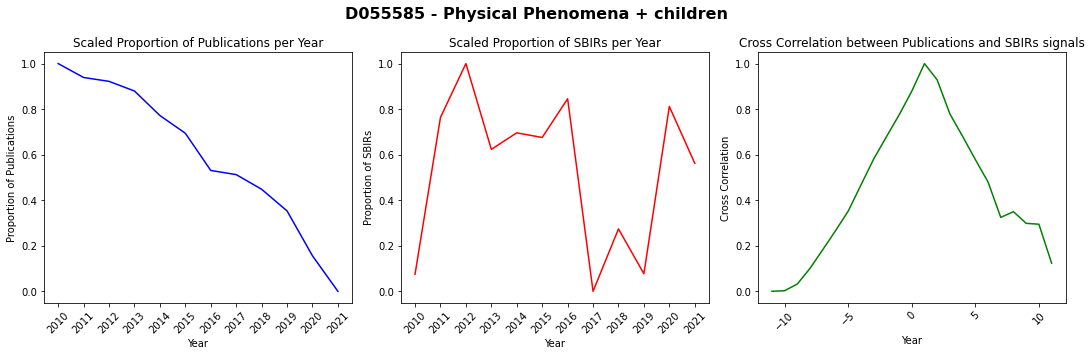

In [22]:
# plot three plots next to each other, one for dui2pubCitSigPropScaled, one for dui2sbCitSigPropScaled, and one for dui2cc
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(str(sample_dui) + ' - ' + sample_name + ' + children', fontsize=16, fontweight='bold')
axs[0].plot(years[START_YEAR_IDX:], dui2pubFreqSigPropScaledchild[sample_dui], color='blue')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Proportion of Publications')
axs[0].set_title('Scaled Proportion of Publications per Year')
axs[1].plot(years[START_YEAR_IDX:], dui2sbFreqSigPropScaledchild[sample_dui], color='red')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Proportion of SBIRs')
axs[1].set_title('Scaled Proportion of SBIRs per Year')
axs[2].plot(correlation_lags, dui2ccchild[sample_dui], color='green')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Cross Correlation')
axs[2].set_title('Cross Correlation between Publications and SBIRs signals')

# calculate the maximum correlation lag
maximum_correlation_lag = correlation_lags[np.argmax(dui2ccchild[sample_dui])]
print('maximum_correlation_lag:', maximum_correlation_lag)
#calcualte the AUC of the cross-correlation signal
zero_index = correlation_lags.index(0)
pos_auc = np.trapz(dui2ccchild[sample_dui][zero_index + 1:], dx=1)
neg_auc = np.trapz(dui2ccchild[sample_dui][:zero_index], dx=1)
ccauc = (pos_auc + 1) / (neg_auc + 1)

print('pos_auc:', pos_auc)
print('neg_auc:', neg_auc)
print('ccauc:', ccauc)

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

depth: 1
len(dui_subset_mcclags): 0
neg: 0 Ratio: 0.0
zero: 0 Ratio: 0.0
pos: 0 Ratio: 0.0
depth: 2
len(dui_subset_mcclags): 58
neg: 0 Ratio: 0.0
zero: 10 Ratio: 17.241379310047563
pos: 48 Ratio: 82.7586206882283


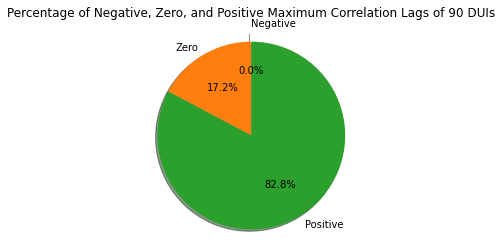

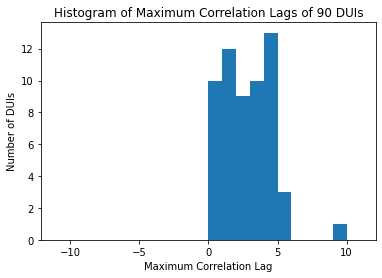

depth: 3
len(dui_subset_mcclags): 853
neg: 104 Ratio: 12.192262602564838
zero: 134 Ratio: 15.709261430227775
pos: 615 Ratio: 72.09847596709015


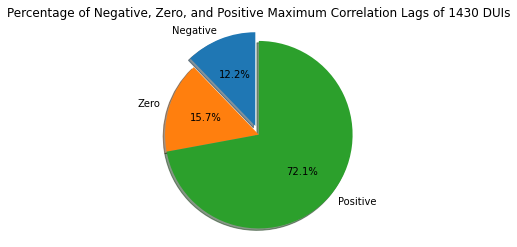

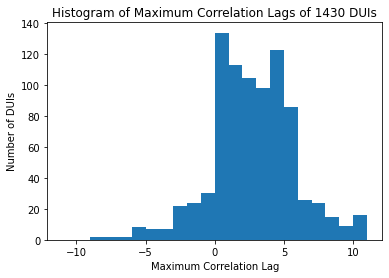

depth: 4
len(dui_subset_mcclags): 2976
neg: 395 Ratio: 13.27284946236113
zero: 447 Ratio: 15.020161290317532
pos: 2134 Ratio: 71.70698924728774


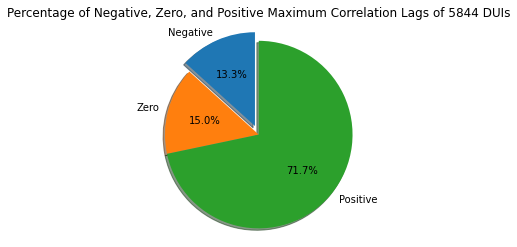

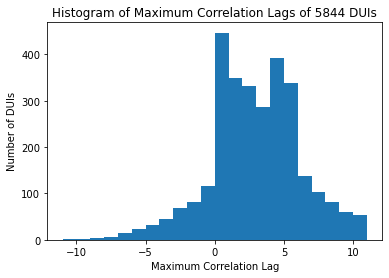

depth: 5
len(dui_subset_mcclags): 5653
neg: 827 Ratio: 14.629400318412412
zero: 805 Ratio: 14.240226428442554
pos: 4021 Ratio: 71.13037325312733


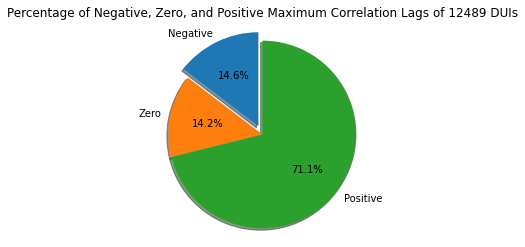

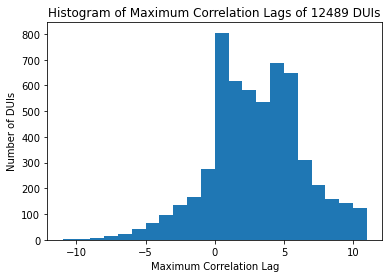

depth: 6
len(dui_subset_mcclags): 7880
neg: 1130 Ratio: 14.34010152284082
zero: 1083 Ratio: 13.743654822333282
pos: 5667 Ratio: 71.9162436548132


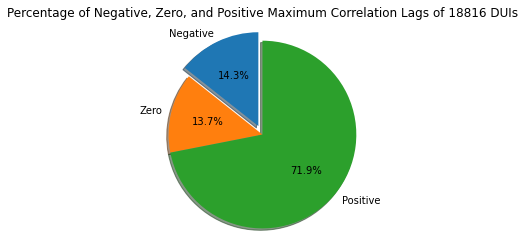

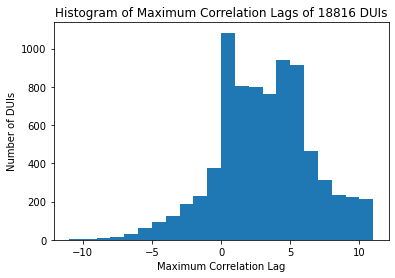

depth: 7
len(dui_subset_mcclags): 9283
neg: 1328 Ratio: 14.305720133575967
zero: 1251 Ratio: 13.476246902939407
pos: 6704 Ratio: 72.21803296347386


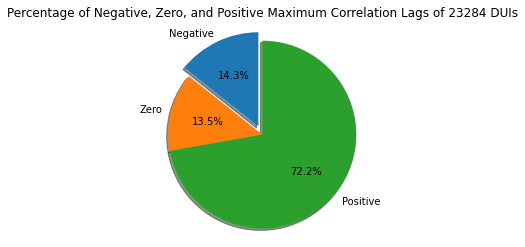

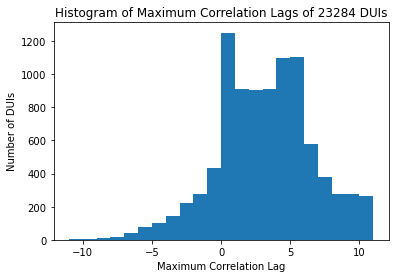

depth: 8
len(dui_subset_mcclags): 10019
neg: 1435 Ratio: 14.322786705258576
zero: 1331 Ratio: 13.284758957978513
pos: 7253 Ratio: 72.39245433675293


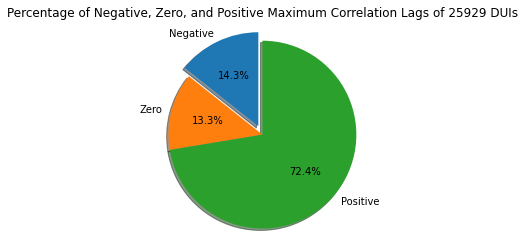

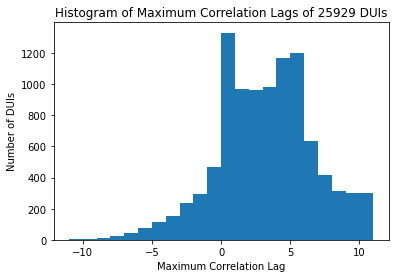

depth: 9
len(dui_subset_mcclags): 10491
neg: 1508 Ratio: 14.374225526640513
zero: 1383 Ratio: 13.182728052615273
pos: 7600 Ratio: 72.44304642073467


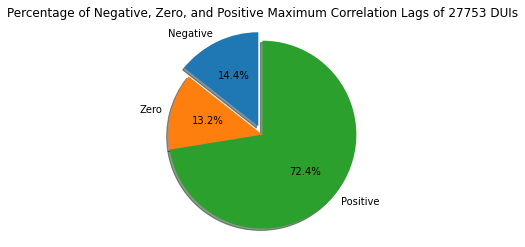

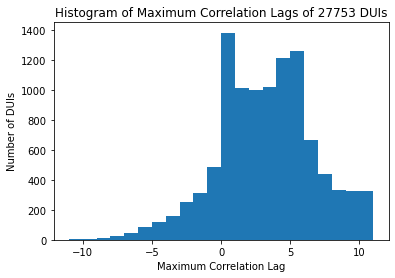

depth: 10
len(dui_subset_mcclags): 10714
neg: 1546 Ratio: 14.429718125815342
zero: 1409 Ratio: 13.151017360461717
pos: 7759 Ratio: 72.4192645137136


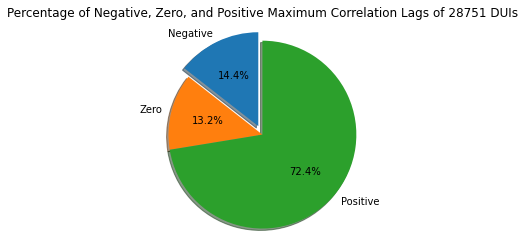

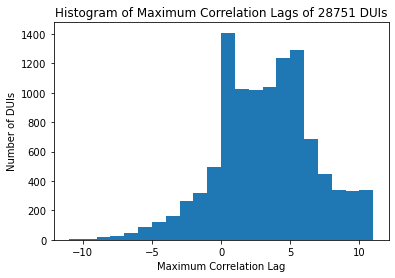

depth: 11
len(dui_subset_mcclags): 10822
neg: 1567 Ratio: 14.479763444833257
zero: 1424 Ratio: 13.15838107558555
pos: 7831 Ratio: 72.36185547957194


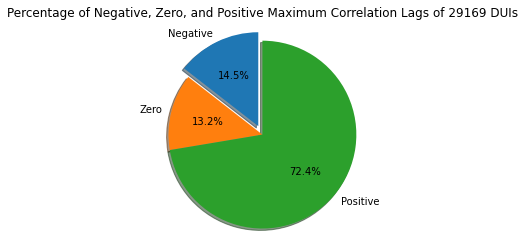

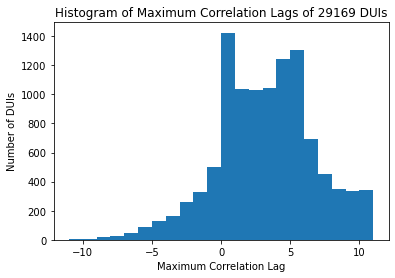

depth: 12
len(dui_subset_mcclags): 10853
neg: 1570 Ratio: 14.46604625449051
zero: 1428 Ratio: 13.157652262046145
pos: 7855 Ratio: 72.37630148345411


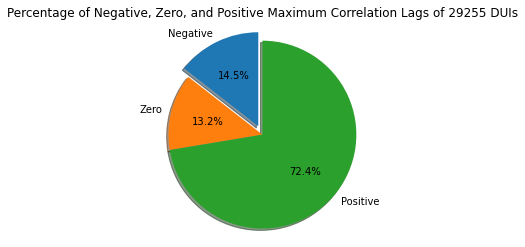

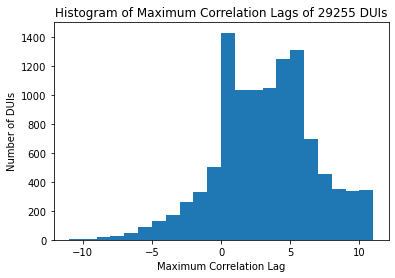

depth: 13
len(dui_subset_mcclags): 10864
neg: 1571 Ratio: 14.460603829159199
zero: 1429 Ratio: 13.153534609718964
pos: 7864 Ratio: 72.38586156111263


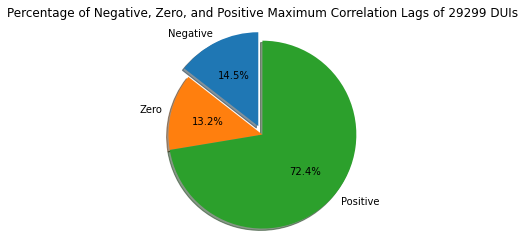

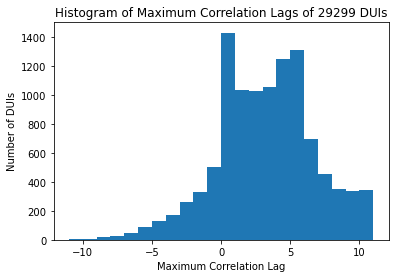

depth: 14
len(dui_subset_mcclags): 10873
neg: 1572 Ratio: 14.457831325299875
zero: 1429 Ratio: 13.142646923570942
pos: 7872 Ratio: 72.39952175111998


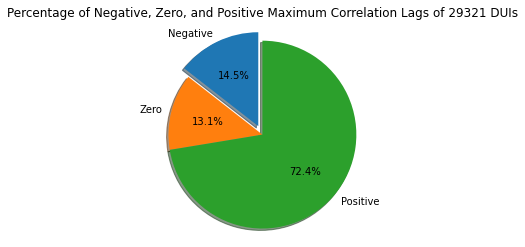

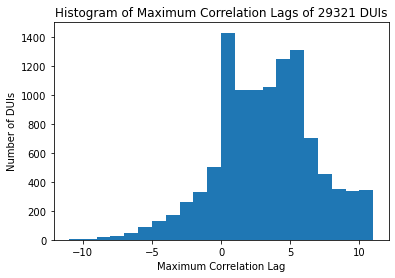

In [23]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
for depth in range(max_depth + 1):
    print('depth:', depth + 1)
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level]]
    dui_subset_mcclags = [dui2mcclagchild[dui] for dui in dui_subset if dui in dui2mcclagchild]
    print('len(dui_subset_mcclags):', len(dui_subset_mcclags))
    neg = len([lag for lag in dui_subset_mcclags if lag < 0])
    zero = len([lag for lag in dui_subset_mcclags if lag == 0])
    pos = len([lag for lag in dui_subset_mcclags if lag > 0])
    # print the true value and percentage of negative, zero, and positive maximum correlation lags add 0.000000001 to avoid division by zero
    print('neg:', neg, 'Ratio:', neg / (len(dui_subset_mcclags) + 0.000000001) * 100)
    print('zero:', zero, 'Ratio:', zero / (len(dui_subset_mcclags) + 0.000000001) * 100)
    print('pos:', pos, 'Ratio:', pos / (len(dui_subset_mcclags) + 0.000000001) * 100)

    if neg + zero + pos == 0:
        print('=' * 50)
        continue

    # plot the three accuracy scores as a pie graph. choose the one pie graph that is empty in the middle   
    labels = 'Negative', 'Zero', 'Positive'
    sizes = [neg, zero, pos]
    explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    fig1.patch.set_facecolor('white')
    plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.show()

    # plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -11 to 11 with 1 intervals
    plt.hist(dui_subset_mcclags, bins=range(-11, 12, 1))
    plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.xlabel('Maximum Correlation Lag')
    plt.ylabel('Number of DUIs')
    plt.show()
    
    print('=' * 50)

depth: 0
len(dui_subset_mcclags) 0
[]
neg: 0 Ratio: 0.0
pos: 0 Ratio: 0.0
depth: 1
len(dui_subset_mcclags) 58
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.610036

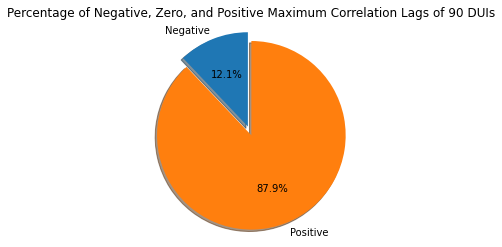

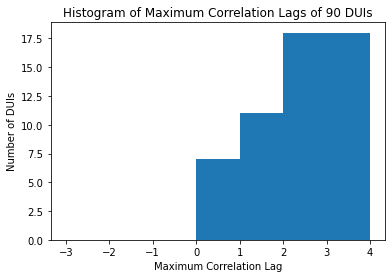

depth: 2
len(dui_subset_mcclags) 853
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 0.

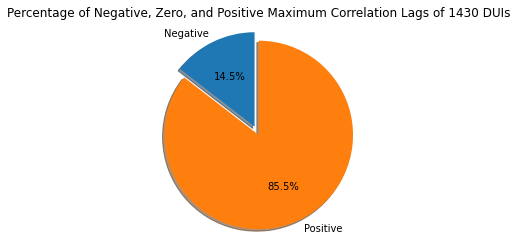

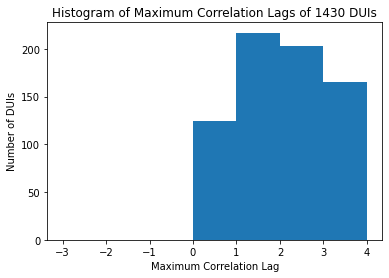

depth: 3
len(dui_subset_mcclags) 2976
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 0

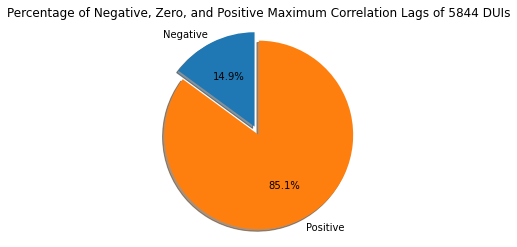

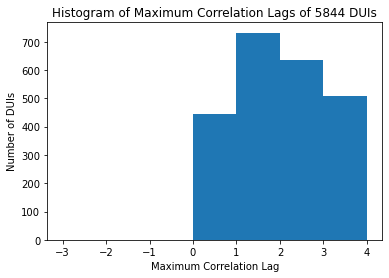

depth: 4
len(dui_subset_mcclags) 5653
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 0

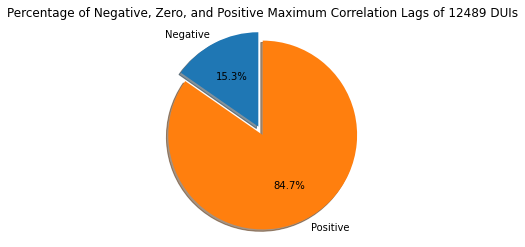

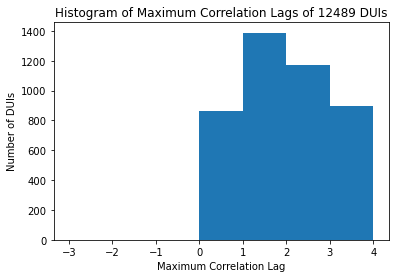

depth: 5
len(dui_subset_mcclags) 7880
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 0

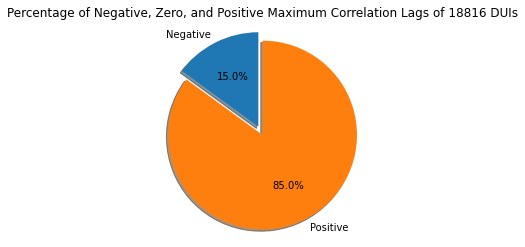

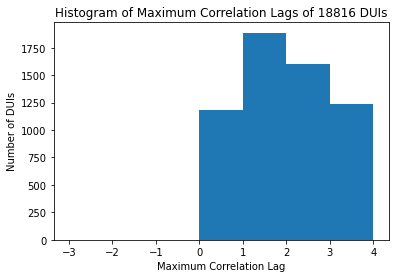

depth: 6
len(dui_subset_mcclags) 9283
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 0

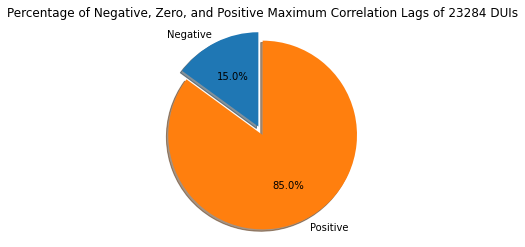

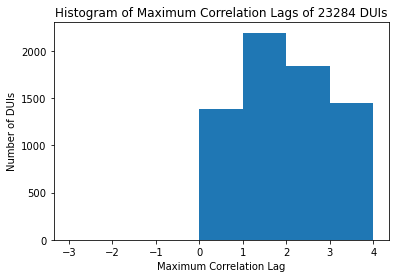

depth: 7
len(dui_subset_mcclags) 10019
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 

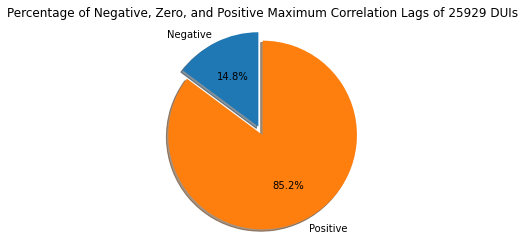

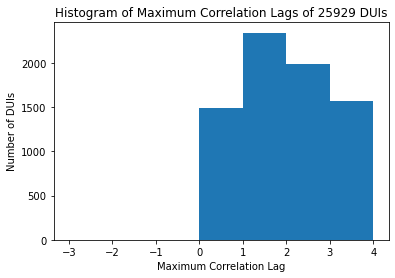

depth: 8
len(dui_subset_mcclags) 10491
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 

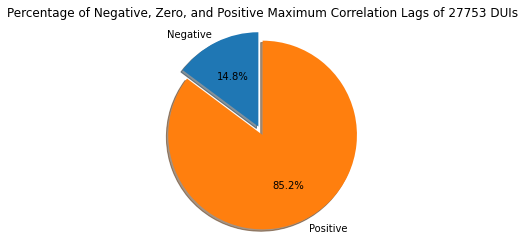

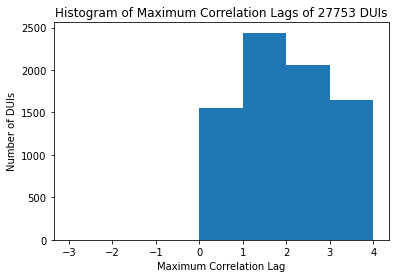

depth: 9
len(dui_subset_mcclags) 10714
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815, 

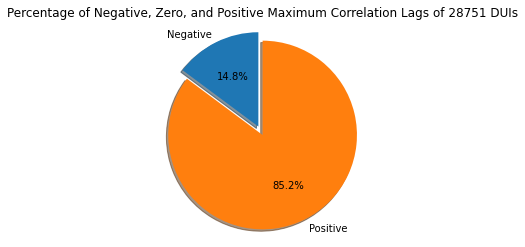

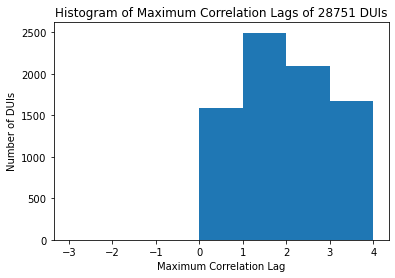

depth: 10
len(dui_subset_mcclags) 10822
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815,

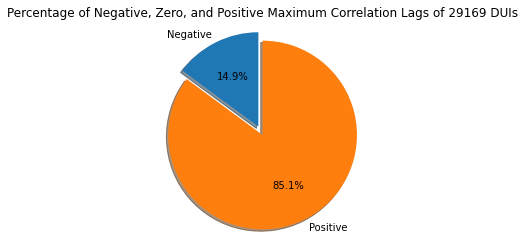

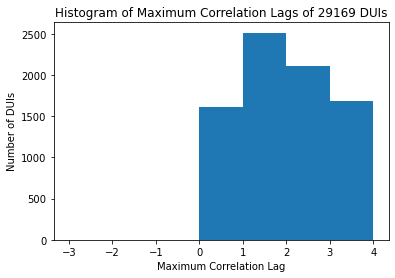

depth: 11
len(dui_subset_mcclags) 10853
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815,

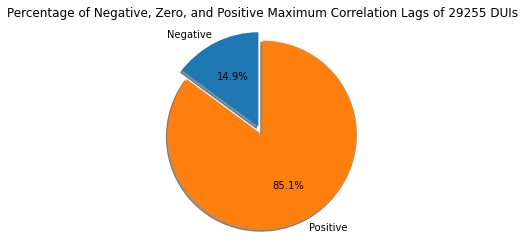

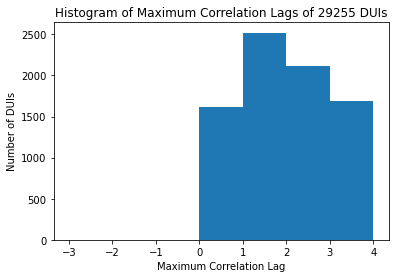

depth: 12
len(dui_subset_mcclags) 10864
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815,

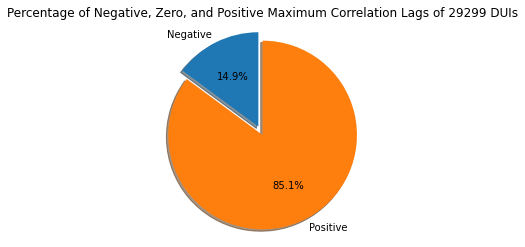

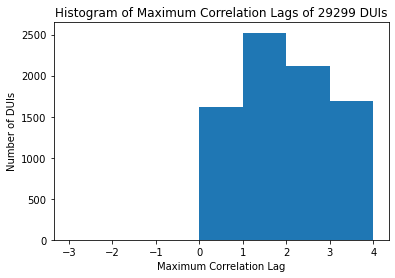

depth: 13
len(dui_subset_mcclags) 10873
[1.129143215795448, 2.6924687021049274, 3.451040887737036, 1.2230515457262585, 2.2753599089605605, 3.2684575464503314, 2.2146306538199134, 2.932556955534714, 2.697711663718507, 1.7825717921059585, 3.0319052189992797, 2.705549780853318, 2.9600007022537387, 2.1304569256353187, 2.294003155977746, 2.0373438228850014, 4.498736016712106, 1.261693660560868, 3.8457740625514414, 4.075507307918464, 1.2438802426768982, 2.7776045486562686, 2.92286294550214, 4.26559011315313, 2.9923340235062312, 3.4941165784583235, 1.547917670927949, 3.9063897922708346, 3.6749221852235614, 1.6995375809787927, 2.193058793098164, 2.1131761274612715, 3.9252394284681777, 3.0035346804599765, 3.3240950711031334, 1.351542205710871, 1.7860386085800704, 3.8125191608415188, 3.829132985537733, 4.056616459444446, 3.6838556084943765, 1.6338668826676859, 3.8489203221385795, 0.790827778302473, 3.5810861399483525, 0.6100360778430174, 2.7796095753734704, 2.1688675075730037, 1.878505968445815,

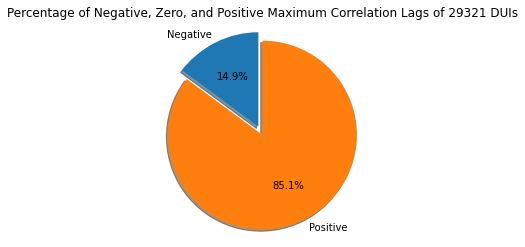

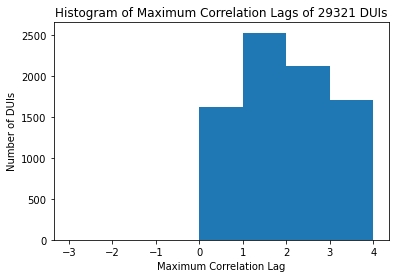

In [24]:
# iterate over max_depth and create a histogram of the maximum correlation lags of duis in dui_subset, then plot it
max_depth = 13
for depth in range(max_depth + 1):
    print('depth:', depth)
    dui_subset = [dui for level in range(depth + 1) for dui in level2duis[level]]
    dui_subset_mcclags = [dui2aucratiochild[dui] for dui in dui_subset if dui in dui2aucratiochild]
    print('len(dui_subset_mcclags)', len(dui_subset_mcclags))
    print(dui_subset_mcclags)
    neg = len([lag for lag in dui_subset_mcclags if lag <= 1])
    pos = len([lag for lag in dui_subset_mcclags if lag > 1])
    ppos = pos / (len(dui_subset_mcclags) + 0.000000001) * 100
    pneg = neg / (len(dui_subset_mcclags) + 0.000000001) * 100
    # print the true value and percentage of negative, zero, and positive maximum correlation lags add 0.000000001 to avoid division by zero
    print('neg:', neg, 'Ratio:', pneg)
    print('pos:', pos, 'Ratio:', ppos)

    if neg + pos == 0:
        print('=' * 50)
        continue

    # plot the three accuracy scores as a pie graph. choose the one pie graph that is empty in the middle   
    labels = 'Negative', 'Positive'
    sizes = [neg, pos]
    explode = (0.1, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    fig1.patch.set_facecolor('white')
    plt.title('Percentage of Negative, Zero, and Positive Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.show()

    # plot the histogram of the maximum correlation lags of dui_subset_mcclags. bound the x-axis to -3 to 5 with 1 intervals
    plt.hist(dui_subset_mcclags, bins=range(-3, 5, 1))
    plt.title('Histogram of Maximum Correlation Lags of ' + str(len(dui_subset)) + ' DUIs')
    plt.xlabel('Maximum Correlation Lag')
    plt.ylabel('Number of DUIs')
    plt.show()

    #save pos / (len(dui_subset_mcclags) + 0.000000001) * 100 to a txt file named like STIDX_<START_FROM_IDX>_DEPTH_<depth>.txt at data/SF11/results
    with open(LAG_DATA_ADDRESS + SF_TAG + '/results/DEPTH_' + str(depth) + '_FREQ.txt', 'w') as f:
        f.write(str(pos / (len(dui_subset_mcclags) + 0.000000001) * 100))
    
    print('=' * 50)